In [ ]:
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:75% !important; }</style>"))

# Baseball Pitch Data Exploration
I have played baseball my entire life, everything about the game interests me and I enjoy exploring different baseball data sets. Today I will be diving into some baseball pitch data and visualizing the trends of different pitches with respect to different counts (strikes/balls), running positions (which bases are occupied), zones (where ball crossed plate), release speed (mph), and pitch types (Fastball, Curve, etc.). The purpose of this exploration is to see what trends emerge from the data as different parameters are filtered. This makes the use of scatter plots ideal, because the pitch x and z coordinates represent two numeric values which can be plotted independent of any other points. After exploration is complete, the next steps could include building a prediction model to determine what pitch type will be thrown next, as well as where it will cross the plate.

# Scatter Plot Visualization Technique
A Scatter plot is a visualization which plots point based on two different variables (x and y components). Points on scatter plots are not connected to one another.
Scatter plots are primarily used to show relationships between two variables (numeric). The points on a scatter plot can aid one in determining trends within the data.
The points on scatter plots can be adjusted to change shape, color, and size depending on what it is you want to visualize. 

In this notebook, I will be using scatter
plots to plot baseball pitch locations based on their X and Z components when crossing home plate. The final scatter plot will also be interactive to allow for other
explorations into how pitch location changes based on pitch type, count, bases occupied, and count.

___

# Considerations for Library Selection
As mentioned above, the purpose of this notebook is to plot pitch data using scatter plots. The total number of pitches thrown per season is usually greater than 250,000.
In order to plot pitch data across a single year and/or multiple years I need to use a library that has the ability to handle big data sets. Being able to handle big data
and work fast is needed because of the need for interactivity at the end. This immediately eliminated altair, as the max number of points allowed by default with altair 
is 5,000. If you do disable the maximum with altair or use the .url extension for your data, it still takes a while to render which is not ideal for interactivity. 
Matplotlib or Seaborn could be used, but I wanted to explore a different library outside what I would typically use.

# Plotly Library 

The plotly Python library (plotly.py) is an open-source graphing library which supports over 40 chart types. It is built on top of the Plotly JavaScript library (plotly.js)
which enables users to create visualizations that have the flexibility to be displayed in Jupyter notebooks, python built web apps using Dash (made by plotly), and HTML files.
The library source code is kept on GitHub and users are able to view, report issues,
and contribute to that code if they choose. Plotly's website has a lot of Figure and API reference information as well as examples for the various graphing options
they currently have. If they do not have something you need, the fact that it is open-source gives you the ability to contribute once you have created the visualization
you need. These points make plotly an excellent choice. 

website: https://plot.ly/python/

### Scatter GL
Now that I selected the library I am going to use, I needed to figure out the best way to handle the large amount of data that will be plotted. Plotly has a Scatter()
function that can take your x and y components and generate a scatter plot for you. This works fine, but as mentioned above I will have a lot of data to plot and I
want to create an interactive plot, so after doing more research I found a companion function Scattergl() which implements WebGL and increases speed and improves 
interactivity. This will be perfect for plotting a lot of pitches.





# Installing Plotly

#### To install plotly using pip, type the following command:

$ pip install plotly==4.3.0


#### To install plotly using conda, type the following command:

$ conda install -c plotly plotly=4.3.0

# Import Libraries
The following libraries will be used for data cleaning and visualizations

In [ ]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go


# Collecting and Clean Data

I will be using baseball pitch data collected from https://baseballsavant.mlb.com/. Due to file size, there are issues when exporting from baseball savant. To get around this limitation the pitch data is stored in monthly segments for the regular season and as a single file for the post season in each year.

https://baseballsavant.mlb.com/statcast_search

### Instructions for downloading [Pitch Data](https://baseballsavant.mlb.com/statcast_search):
- Specify the Player Type:, Season:, Game Date >=, Game Date <=, and Season Type: for the block of time you want to grab (note: use one month intervals)
- Click Search
- In the Header of the Search Results, click on the icon at far right which displays Download Data as Comma Separated Values File when you scroll over it
- Save the data in a folder named pitch_data using a standard naming convention

### Standardized Naming for Data
A standard naming convention of 'reg_' + month[:3] + str(year) + '.csv' was used for each regular season datafile, while the post season files were saved as 'post_' + str(year) + '.csv'

### Example Query
Player Type: Pitcher, Season: 2019, Game Date >= 2019-03-01, Game Date <= 2019-03-31, Season Type: Regular Season

save as: reg_Mar2019.csv



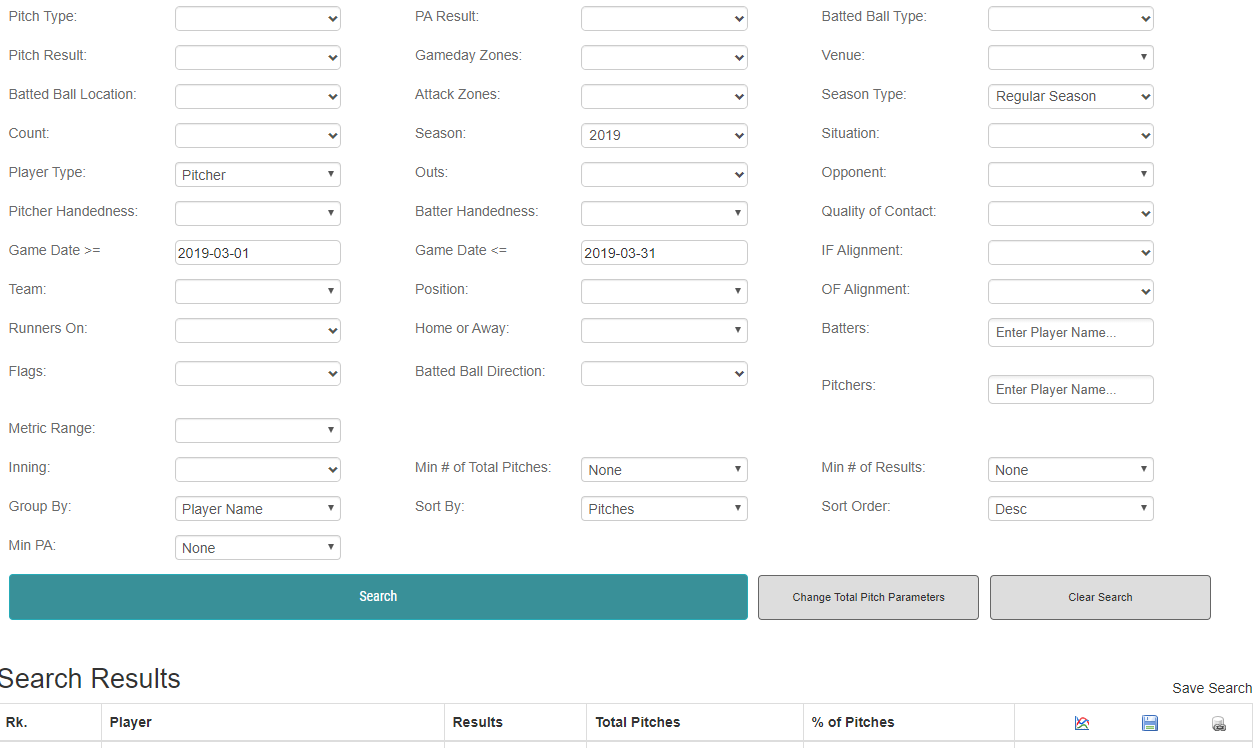

In [ ]:
# With a standardized naming convention used for all files, I will create a function to output a list of all the file names needed for vizualization

def datafiles(months, years, season):
    ''' file name generator based on given months and years to be included
    months - months to be included [list of months, as str]
    years - years to be included [list of years, as int]
    season - regular season, post season, or both [reg, post, or both as str]'''
    files = []
    for year in years:
        if season != 'post':
            for month in months:
                files.append('reg_' + month + str(year) + '.csv')
        if season != 'reg':
            files.append('post_' + str(year) + '.csv')
    return files

# Specify Months and Years you want to include in analysis - Months are Mar - Sep
# to limit the size of data being uploaded, only 2019 was included

months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'] # Baseball Regular Season runs March through September
years = [2019] # Only included data from 2019 into this tutorial notebook due to size of data files
        
dfiles = datafiles(months, years, 'both')

In [ ]:
# Now we can print the datafile list to verify we didn't miss anything
print(dfiles)

In [ ]:
# We have our list of datafiles needed (dfiles) so we can now read in each file as a dataframe using pd_r and then combine them using pd_concat. These functions
# use the pandas.read_csv, pandas.read_html, and pandas.concat methods to create a single dataframe for all data specified in dfiles

def pd_r(file):
    ''' pandas dataframe read function
    file - file name (and location if outside of root folder) as str'''
    if file.split('.')[1] == 'csv':
        df = pd.read_csv('pitch_data/' + file)
    if file.split('.')[1] == 'html':
        df = pd.read_html('pitch_data/' + file)
    return df

def pd_concat(files):
    ''' pandas dataframe df concat function
    files - files to merge [list of str]
    pd_r - a pandas read function specified above'''
    df = pd_r(files[0])
    for i in range(len(files)-1):
        df2 = pd_r(files[i+1])
        df = pd.concat([df, df2])
    return df

pitch_data = pd_concat(dfiles)

In [ ]:
# Check the head of the pitch data dataframe (df)
pitch_data.head()

In [ ]:
# Time to clean the data and split up the month, day, year information. We will also limit the columns in the cleaned df as we will only be using a portion of the entire dataframe for this tutorial

def clean_df(df):
    ''' dataframe structure cleaner
    df - dataframe to clean [pandas df]'''
    df['game_date'] = pd.to_datetime(df['game_date'])
    df['month'] = df['game_date'].apply(lambda x:x.date().strftime('%m')) # month value
    df['day'] = df['game_date'].apply(lambda x:x.date().strftime('%d')) # day of month value
    df['year'] = df['game_date'].apply(lambda x:x.date().strftime('%y')) # year value
    df['on_1b'] = df['on_1b'].fillna(0) # Replace NaN with 0
    df['on_2b'] = df['on_2b'].fillna(0) # Replace NaN with 0
    df['on_3b'] = df['on_3b'].fillna(0) # Replace NaN with 0
    df2 = df[['game_date', 'month', 'day', 'year', 'pitch_type', 'pitch_name', 'release_speed', 'plate_x', 'plate_z', 'zone', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']] # Columns to keep
    return df2

pitch = clean_df(pitch_data)

In [ ]:
pitch.head()

# Plotting the Data
Now that the data is cleaned, it is time to start creating the visualizations to get a better understanding of the pitch data.

As mentioned earlier, plotly has a few ways to create scatter plots:
- **plotly.express** - below is a screen shot of visualizing the first 5000 rows of the pitch dataframe created above using plotly.express.
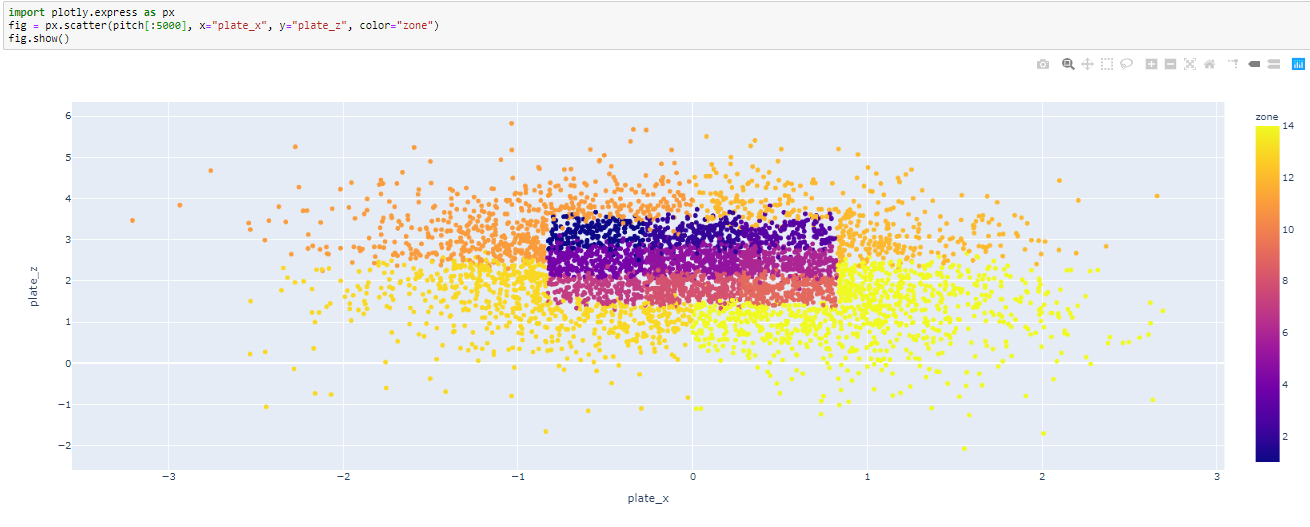
- **plotly.go.Scatter** - below is a screen shot of visualizing the first 5000 rows of the pitch dataframe created above using go.Scatter.
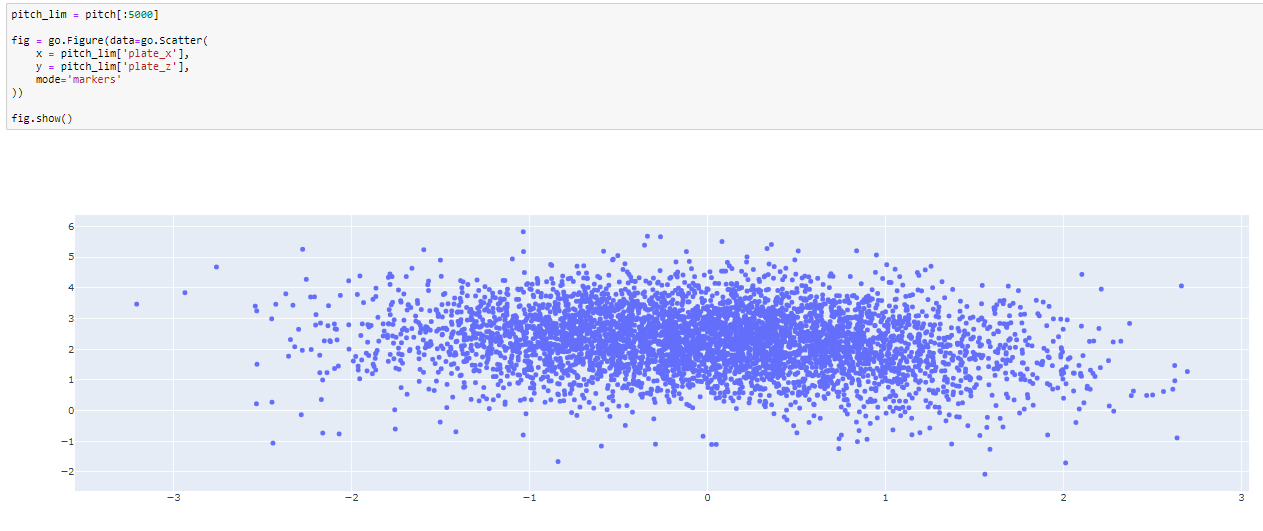

Due to the size of the dataframe, it takes a long time to render the images using these two methods. This data is an edge case for using the **Scattergl** method because it utilizes WebGL which is meant for big data. Using WebGL allows for the entirity of the pitch data to be included in the interactive visualizations. If you want to experience the delays for yourself, copy the code from the above images and run them to see for yourself. It will take much longer than WebGL.

### Basic Scatter Plot using go.Scattergl
We imported the plotly.graph_objects earlier
> **import** plotly.graph_objects **as** go

In [ ]:
# for the x and y components of the scatter plot, I want to use plate_x and plate_z. plotly allows you to use a pd series from a dataframe so we pass the arguments as you will see below

def plotly_scatter(df):
    '''plotly scattergl function
    df - dataframe'''
    fig = go.Figure(data=go.Scattergl(
    x = df['plate_x'],
    y = df['plate_z'],
    mode='markers'))
    fig.show()
    
plotly_scatter(pitch)

### Getting a little more info included in the Basic Scatter Plot
We have the basic plot code, next we will add code to specify marker properties:
- color
- color scale
- line width

In [ ]:
# Now that we have generated a basic plot, we will add more detail into the plot to make it more effective at communicating what the data is
# You will see that the first four lines of code are the same, and the new addition is marker=dict( *args) 

def plotly_scatter(df):
    '''plotly scattergl function
    df - dataframe'''
    fig = go.Figure(data=go.Scattergl(
    x = df['plate_x'],
    y = df['plate_z'],
    mode='markers',
    marker=dict(
        color=df['zone'],
        colorscale='RdBu',
        line_width=1)))
    fig.show()
    
plotly_scatter(pitch)

### Update plot with titles, x/y limits, figure size, and autosizing 
We will take the code used to generate the plot above and add in additional configuration parameters:

- width
- height
- xaxis
- yaxis
- update x/y axes, layout

By specifying these parameters, it will lock the x and y height and axis scales of the plot so that as data is filtered, the image size will remain the same but with different data points displayed. This will be very helpful when analyzing pitch location trends with differing conditions. The update commands allow for labels to be put on the x and y axes as well as shifting the location of the chart title.


In [ ]:
def plotly_scatter(df):
    '''plotly scattergl function
    df - dataframe'''
    fig = go.Figure(data=go.Scattergl(
    x = df['plate_x'],
    y = df['plate_z'],
    mode='markers',
    marker=dict(
        color=df['zone'],
        colorscale='RdBu',
        line_width=1)
    ),layout = go.Layout(
    autosize=False,
    width=600,
    height=700,
    xaxis=dict(range=[-4, 4]),
    yaxis=dict(range=[-2, 7]))
    )
    fig.update_xaxes(title_text='Plate_X (ft)')
    fig.update_yaxes(title_text='Plate_Z (ft)')
    fig.update_layout(title=go.layout.Title(
        text='Pitch Location X vs Z',
        xref='paper',
        x=0.3
    ))
    fig.show()
    
plotly_scatter(pitch)

## Interactive Plotly Scattergl Plot
Now that we have a nice looking static scatter plot, it is time to build in interactivity so that we can explore the data further. 

We imported the ipywidgets modules earlier:

>**import** ipywidgets **as** widgets

>**from** ipywidgets **import** interact

We will build in sliders and drop downs for the following variables:

- **zone** (which part of the strike zone a pitch crosses the plate in {1-9 are considered 'strikes', 10-14 are considered 'balls' if batter does not swing}

- **strike** (how many strikes are in the count at time of pitch)

- **ball** (how many balls are in the count at time of pitch)

- **speed** (release speed of pitch)

- **bases** (which bases are occupied {Loaded, Empty, Any}

- **pitchname** (what pitch type do you want to filter on)

The use of plotly scattergl allows for the use of interactivity while not crashing your computer as you investigate the data. As described earlier, other libraries cannot handle the amount of data being passed from the pitch dataframe in its entirety. Even plotly's own regular scatter and plotly.express scatter methods can not handle big data in a time efficient manner. Plotly's scattergl method also allows the use of a built in plotly interactive feature which allows you to scroll over the data points and see the coordinates. These are especially nice things to have when looking at pitch data. Strike zones can be subjective, so being able to see coordinates of different pitches labeled strikes or balls is interesting. It could allow further research to be done in developing classification algorithms to decide whether strikes and balls from different umpires are biased.

In [ ]:
# Time to build the interactive visualization
# This will be done with the @interact command followed by code for each slider that will be used. ipywidgets has additional documentation on their website for those who want to learn more

@interact(zone = widgets.IntRangeSlider(
    value=[1, pitch['zone'].dropna().max()],
    min=1,
    max=pitch['zone'].dropna().max(),
    step=1,
    description='Zones:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
),strike = widgets.IntRangeSlider(
    value=[0, 2],
    min=0,
    max=2,
    step=1,
    description='Strikes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
),ball = widgets.IntRangeSlider(
    value=[0, 3],
    min=0,
    max=3,
    step=1,
    description='Balls:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
),speed = widgets.IntRangeSlider(
    value=[pitch['release_speed'].dropna().min(), pitch['release_speed'].dropna().max()],
    min=pitch['release_speed'].dropna().min(),
    max=pitch['release_speed'].dropna().max(),
    step=1,
    description='Speed:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
),bases = widgets.Dropdown(
    options=[('Any Base',0), ('Empty', 1), ('Loaded', 2)],
    value=0,
    description='Runners:',
),pitchname = widgets.Dropdown(
    options=[('Slider',0), ('4-Seam Fastball', 1), ('Changeup', 2), ('2-Seam Fastball', 3),
            ('Cutter',4), ('Curveball',5), ('Sinker',6), ('Split Finger',7), ('Knuckle Curve',8),
            ('Eephus',9), ('Knuckle Ball',10), ('Forkball',11), ('All',12)],
    value=12,
    description='Pitch:',
)
)

def pitch_number(zone, strike, ball, speed, bases, pitchname):
    pitches = pitch['pitch_name'].dropna().unique()     
    df2 = pitch[(pitch['zone']>=zone[0]) & (pitch['zone']<=zone[1])]
    df2 = df2[(df2['release_speed']>=speed[0]) & (df2['release_speed']<=speed[1])]
    df2 = df2[(df2['strikes']>=strike[0]) & (df2['strikes']<=strike[1])]
    df2 = df2[(df2['balls']>=ball[0]) & (df2['balls']<=ball[1])]
    if bases == 1:
        df2 = df2[(df2['on_3b']==0) & (df2['on_2b']==0) & (df2['on_1b']==0)]
    elif bases == 2:
        df2 = df2[(df2['on_1b']>0) & (df2['on_2b']>0) & (df2['on_3b']>0)]
    if pitchname < 12:
        df2 = df2[df2['pitch_name']==pitches[pitchname]]
    fig = go.Figure(data=go.Scattergl(
    x = df2['plate_x'],
    y = df2['plate_z'],
    mode='markers',
    marker=dict(
        color=df2['zone'],
        colorscale='RdBu',
        line_width=1)
    ),layout = go.Layout(
    autosize=False,
    width=600,
    height=700,
    xaxis=dict(range=[-4, 4]),
    yaxis=dict(range=[-2, 7]))
    )
    fig.update_xaxes(title_text='Plate_X (ft)')
    fig.update_yaxes(title_text='Plate_Z (ft)')
    fig.update_layout(title=go.layout.Title(
        text='Pitch Location X vs Z',
        xref='paper',
        x=0.3
    ))
    fig.show()


# Summary
If you filter on 4-Seam Fastball and a count of 0 balls, 2 strikes (1 strike away from an out) there is a clearly shown trend where balls are typically higher in the strike zone, often times out of the strike zone all together trying to get batters to chase pitches. The Red Blue color scale depicts the 9 zones representing strikes as Red through light blue. The 5 zones representing balls are shown in medium to dark blue.

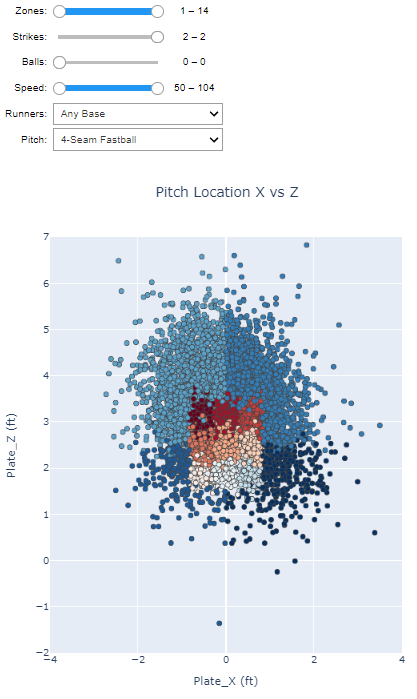

If you instead filter on a count of 3 balls, 0 strikes (1 ball away from a walk) you will see that pitches typically come in much closer to the actual strike zone.

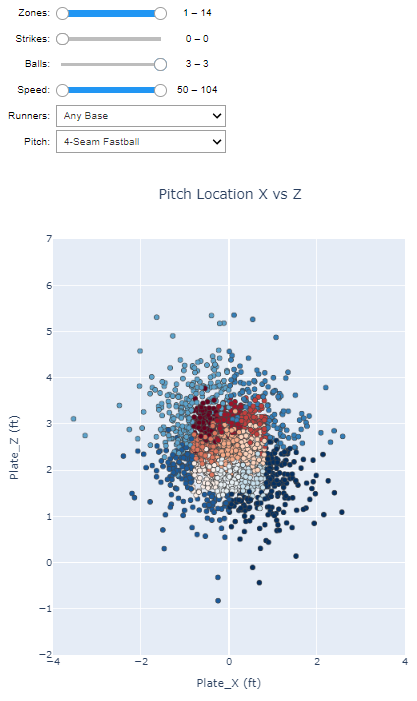

### Use the filters built in to the visualization and enjoy exploring the data!

# Record Dependencies
Below are the dependencies for this notebook

In [ ]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,ipywidgets,plotly